# Create a BERT Sentiment Classifier (Probing / Classification Head)

In [1]:
# Import the datasets and transformers packages

from datasets import load_dataset

# Load the train and test splits of the imdb dataset
splits = ["train", "test"]
ds = {split: ds for split, ds in zip(splits, load_dataset("imdb", split=splits))}

# Thin out the dataset to make it run faster for this example
for split in splits:
    ds[split] = ds[split].shuffle(seed=42).select(range(500))

# Show the dataset
ds

/Users/yanyan/personal-github/workspace-udacity/generative-ai-nanodegree/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'train': Dataset({
     features: ['text', 'label'],
     num_rows: 500
 }),
 'test': Dataset({
     features: ['text', 'label'],
     num_rows: 500
 })}

## Pre-process datasets
Now we are going to process our datasets by converting all the text into tokens for our models. You may ask, why isn't the text converted already? Well, different models may use different tokenizers, so by converting at train time we retain more flexibility.

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


def preprocess_function(examples):
    """Preprocess the imdb dataset by returning tokenized examples."""
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_ds = {}
for split in splits:
    tokenized_ds[split] = ds[split].map(preprocess_function, batched=True)

tokenized_ds

# Check that we tokenized the examples properly
assert tokenized_ds["train"][0]["input_ids"][:5] == [101, 2045, 2003, 2053, 7189]

# Show the first example of the tokenized training set
print(tokenized_ds["train"][0]["input_ids"])

Map: 100%|██████████| 500/500 [00:00<00:00, 3486.46 examples/s]

[101, 2045, 2003, 2053, 7189, 2012, 2035, 2090, 3481, 3771, 1998, 6337, 2099, 2021, 1996, 2755, 2008, 2119, 2024, 2610, 2186, 2055, 6355, 6997, 1012, 6337, 2099, 3504, 15594, 2100, 1010, 3481, 3771, 3504, 4438, 1012, 6337, 2099, 14811, 2024, 3243, 3722, 1012, 3481, 3771, 1005, 1055, 5436, 2024, 2521, 2062, 8552, 1012, 1012, 1012, 3481, 3771, 3504, 2062, 2066, 3539, 8343, 1010, 2065, 2057, 2031, 2000, 3962, 12319, 1012, 1012, 1012, 1996, 2364, 2839, 2003, 5410, 1998, 6881, 2080, 1010, 2021, 2031, 1000, 17936, 6767, 7054, 3401, 1000, 1012, 2111, 2066, 2000, 12826, 1010, 2000, 3648, 1010, 2000, 16157, 1012, 2129, 2055, 2074, 9107, 1029, 6057, 2518, 2205, 1010, 2111, 3015, 3481, 3771, 3504, 2137, 2021, 1010, 2006, 1996, 2060, 2192, 1010, 9177, 2027, 9544, 2137, 2186, 1006, 999, 999, 999, 1007, 1012, 2672, 2009, 1005, 1055, 1996, 2653, 1010, 2030, 1996, 4382, 1010, 2021, 1045, 2228, 2023, 2186, 2003, 2062, 2394, 2084, 2137, 1012, 2011, 1996, 2126, 1010, 1996, 5889, 2024, 2428, 2204, 1998, 6

## Load and set up the model
We will now load the model and freeze most of the parameters of the model: everything except the classification head.

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label={0: "NEGATIVE", 1: "POSITIVE"},  # For converting predictions to strings
    label2id={"NEGATIVE": 0, "POSITIVE": 1},
)

# Freeze all the parameters of the base model
# Hint: Check the documentation at https://huggingface.co/transformers/v4.2.2/training.html
for param in model.base_model.parameters():
    param.requires_grad = False

model.classifier

## Let's train it!

Now it's time to train our model. We'll use the `Trainer` class from the 🤗 Transformers library to do this. The `Trainer` class provides a high-level API that abstracts away a lot of the training loop.

First we'll define a function to compute our accuracy metric then we make the `Trainer`.

Let's take this opportunity to learn about the `DataCollator`. According to the HuggingFace documentation:

> Data collators are objects that will form a batch by using a list of dataset elements as input. These elements are of the same type as the elements of train_dataset or eval_dataset.

> To be able to build batches, data collators may apply some processing (like padding).

In [ ]:
import numpy as np
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}


# The HuggingFace Trainer class handles the training and eval loop for PyTorch for us.
# Read more about it here https://huggingface.co/docs/transformers/main_classes/trainer
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./data/sentiment_analysis",
        learning_rate=2e-3,
        # Reduce the batch size if you don't have enough memory
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
# Show the performance of the model on the test set
trainer.evaluate()

In [ ]:
import pandas as pd

df = pd.DataFrame(tokenized_ds["test"])
df = df[["text", "label"]]

# Replace <br /> tags in the text with spaces
df["text"] = df["text"].str.replace("<br />", " ")

# Add the model predictions to the dataframe
predictions = trainer.predict(tokenized_ds["test"])
df["predicted_label"] = np.argmax(predictions[0], axis=1)

df.head(2)

In [ ]:
# Show full cell output
pd.set_option("display.max_colwidth", None)

df[df["label"] != df["predicted_label"]].head(2)

## Exercise: Full Fine-tuning BERT

In this exercise, you will create a **BERT-based text classifier** (actually **DistilBERT**) using the [Hugging Face Transformers](https://huggingface.co/transformers/) library. You will perform **full fine-tuning** on the **SMS Spam dataset** from the [datasets](https://huggingface.co/docs/datasets/) package and evaluate your model’s performance.

The **SMS Spam dataset (sms_spam)** contains text messages that are **labeled as either 'ham' (not spam) or 'spam'**, making it a **binary classification problem**. Your goal is to fine-tune a DistilBERT model to accurately classify these messages.

In [1]:
# Load the sms_spam dataset
# See: https://huggingface.co/datasets/sms_spam

from datasets import load_dataset

# The sms_spam dataset only has a train split, so we use the train_test_split method to split it into train and test
dataset = load_dataset("sms_spam", split="train").train_test_split(
    test_size=0.2, shuffle=True, seed=23
)

splits = ["train", "test"]

# View the dataset characteristics
dataset["train"]

/Users/yanyan/personal-github/workspace-udacity/generative-ai-nanodegree/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['sms', 'label'],
    num_rows: 4459
})

In [5]:
dataset["test"]


Dataset({
    features: ['sms', 'label'],
    num_rows: 1115
})

In [4]:
dataset["train"][0]

{'sms': 'Had your mobile 10 mths? Update to the latest Camera/Video phones for FREE. KEEP UR SAME NUMBER, Get extra free mins/texts. Text YES for a call\n',
 'label': 1}

## Pre-process datasets

Now we are going to process our datasets by converting all the text into tokens for our models.

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Let's use a lambda function to tokenize all the examples
tokenized_dataset = {}
for split in splits:
    tokenized_dataset[split] = dataset[split].map(
        lambda x: tokenizer(x["sms"], truncation=True), batched=True
    )

# Inspect the available columns in the dataset
tokenized_dataset["train"]

Map: 100%|██████████| 1115/1115 [00:00<00:00, 48807.62 examples/s]


Dataset({
    features: ['sms', 'label', 'input_ids', 'attention_mask'],
    num_rows: 4459
})

## Load and set up the model

In this case we are doing a full fine tuning, so we will want to unfreeze all parameters.

In [6]:
from transformers import AutoModelForSequenceClassification

# after you do the model loading, take your final nodes at the end and attach a fully connected network to the end (classification head),
# and it should terminate in 2 nodes and from these 2 nodes, we're going to see whether it's spam or not.'
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label={0: "not spam", 1: "spam"},
    label2id={"not spam": 0, "spam": 1},
)


# Unfreeze all the model parameters.
# Hint: Check the documentation at https://huggingface.co/transformers/v4.2.2/training.html
for param in model.parameters():
    param.requires_grad = True

ERROR! Session/line number was not unique in database. History logging moved to new session 13



KeyboardInterrupt



KeyboardInterrupt: 

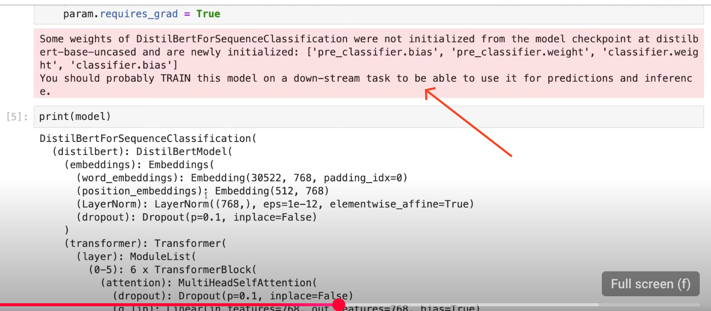

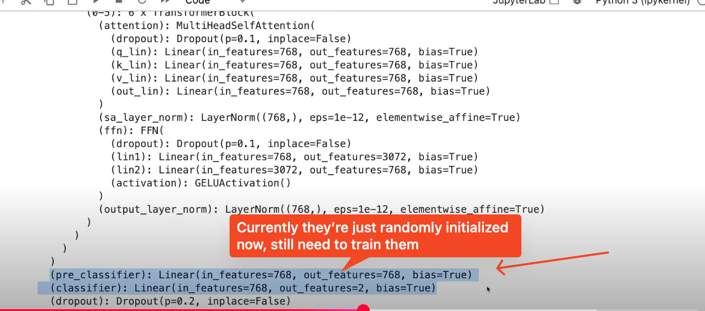

In [ ]:
print(model)

## Let's train it!

Now it's time to train our model. We'll use the `Trainer` class.

First we'll define a function to compute our accuracy metreic then we make the `Trainer`.

In this instance, we will fill in some of the training arguments


In [ ]:
import numpy as np
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}


# The HuggingFace Trainer class handles the training and eval loop for PyTorch for us.
# Read more about it here https://huggingface.co/docs/transformers/main_classes/trainer
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./data/spam_not_spam",
        # Set the learning rate
        learning_rate=2e-5,
        # Set the per device train batch size and eval batch size
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        # Evaluate and save the model after each epoch
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=2,
        weight_decay=0.01,
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
# Show the performance of the model on the test set

trainer.evaluate()

In [ ]:
# Make a dataframe with the predictions and the text and the labels
import pandas as pd

items_for_manual_review = tokenized_dataset["test"].select(
    [0, 1, 22, 31, 43, 292, 448, 487]
)

results = trainer.predict(items_for_manual_review)
df = pd.DataFrame(
    {
        "sms": [item["sms"] for item in items_for_manual_review],
        "predictions": results.predictions.argmax(axis=1),
        "labels": results.label_ids,
    }
)
# Show all the cell
pd.set_option("display.max_colwidth", None)
df